In [1]:
import pandas as pd
import json
data = pd.read_json('/Users/shruhi/Documents/212 Project/Dataset.json', lines = True)
data = pd.DataFrame(data)

In [2]:
import numpy as np
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


We don't need the article_link column, so get rid of it.

In [3]:
data = data.iloc[:,1:]
data.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
print(data.shape)

(26709, 2)


Let's check the target variable distribution

In [5]:
import seaborn
seaborn.countplot(data['is_sarcastic'])

Creating the training and test set 80-20% division using sklearn train_test_split:

We'll start by cleaning the text. In sarastic text, often use of punctuation is important, e.g. sarcastic text tends to have more exclamation points (!), quoatation marks (''), etc. So we won't get rid of punctuation, but rather add it as an attribute called "describe".

Cleaning is done using NLTK (library for NLP), re (library for regex)

In [6]:
import re
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Error loading stopwords: <urlopen error [Errno 8] nodename
[nltk_data]     nor servname provided, or not known>


In [7]:
corpus = []
for i in range(0, len(data)):
    describe = re.sub('!', 'exclamation', data['headline'][i])
    describe = describe.replace('?', 'questionmark')
    quotes = re.findall(r'\'(.+?)\'', describe)
    if quotes:
        describe += 'quotes'
    describe = re.sub('^[a-z]', ' ', describe) #remove everything except lowercase letters
    describe = describe.split()
    stemmer = SnowballStemmer("english", ignore_stopwords=True)
    describe = [stemmer.stem(word) for word in describe]
    describe = ' '.join(describe)
    corpus.append(describe)

Scikit-learn has a high level component which will create feature vectors for us ‘CountVectorizer’.
{Converts a collection of text documents to a matrix of token counts. This implementation produces a sparse representation of the counts using scipy.sparse.csr_matrix.}

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
count_v = CountVectorizer()
x_count = count_v.fit_transform(corpus).toarray()
print(x_count.shape)

(26709, 24833)


By doing ‘count_vect.fit_transform(x_count.data)’, we are learning the vocabulary dictionary and it returns a Document-Term matrix of [n_samples, n_features].

1. Bag of words model:

In [9]:
from sklearn.model_selection import train_test_split
y = data.is_sarcastic

x_train, x_test, y_train, y_test = train_test_split(x_count, y, test_size = 0.2)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(21367, 24833) (21367,)
(5342, 24833) (5342,)


Now we can run an algorithm! 
\n 1.1 Naive Bayes
\n Using NB from sklearn

In [10]:
from sklearn.naive_bayes import BernoulliNB
naivebayes = BernoulliNB().fit(x_train, y_train)
predictednb = naivebayes.predict(x_test)
accuracynb = np.mean(predictednb == y_test)
print('Accuracy is %.2f \n'%accuracynb)
accuracy = {}
accuracy = {'Naive Bayes': accuracynb}

Accuracy is 0.85 




Confusion matrix
 [[2667  333]
 [ 488 1854]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.89      0.87      3000
          1       0.85      0.79      0.82      2342

avg / total       0.85      0.85      0.85      5342


Error is 0.15



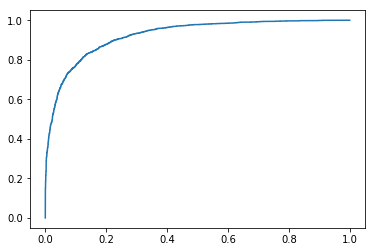

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def output(alg, x_test, y_test, predicted):
    conf_matrix = confusion_matrix(y_test,predicted)
    classf_report = classification_report(y_test,predicted)
    print('\nConfusion matrix\n',conf_matrix)
    print('\nClassification report\n',classf_report)
    prob = alg.predict_proba(x_test)[:,1]
    fpr, tpr, threshold = roc_curve(y_test, prob)
    plt.plot(fpr,tpr)
    TP = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    TN = conf_matrix[1][1]
    error = (FP+FN)/(TP+TN+FP+FN)
    print('\nError is %.2f\n'%error)

output(naivebayes, x_test,y_test,predictednb)

Accuracy for logistic regression
0.84

Confusion matrix
 [[2592  408]
 [ 457 1885]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.86      0.86      3000
          1       0.82      0.80      0.81      2342

avg / total       0.84      0.84      0.84      5342


Error is 0.16



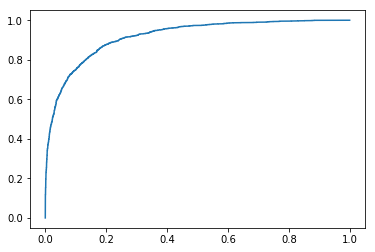

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(x_train,y_train)
predictedLR = logreg.predict(x_test)
accuracyLR = np.mean(predictedLR == y_test)
print("Accuracy for logistic regression\n%.2f"%accuracyLR)
accuracy.update({'Logistic Regression': accuracyLR})

output(logreg,x_test,y_test,predictedLR)

1.2 SGDC Classifier:

This estimator implements regularized linear models with stochastic gradient descent (SGD) learning: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate)

This implementation works with data represented as dense or sparse arrays of floating point values for the features. The model it fits can be controlled with the loss parameter; by default, it fits a linear support vector machine (SVM).

https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html

In [14]:
from sklearn.linear_model import SGDClassifier
sgdcc = SGDClassifier(n_iter=5, random_state=42)
sgdc = sgdcc.fit(x_train, y_train)
predictedsgdc = sgdc.predict(x_test)
accuracysgdc = np.mean(predictedsgdc == y_test)
print('accuracy is %.2f\n'%accuracysgdc)
accuracy.update({'SGDC Classifier': accuracysgdc})

output(sgdc, x_test, y_test, predictedsgdc)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy is 0.82


Confusion matrix
 [[2689  311]
 [ 649 1693]]

Classification report
              precision    recall  f1-score   support

          0       0.81      0.90      0.85      3000
          1       0.84      0.72      0.78      2342

avg / total       0.82      0.82      0.82      5342



AttributeError: probability estimates are not available for loss='hinge'

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


Accuracy for random forest is 0.79


Confusion matrix
 [[2628  372]
 [ 756 1586]]

Classification report
              precision    recall  f1-score   support

          0       0.78      0.88      0.82      3000
          1       0.81      0.68      0.74      2342

avg / total       0.79      0.79      0.79      5342


Error is 0.21



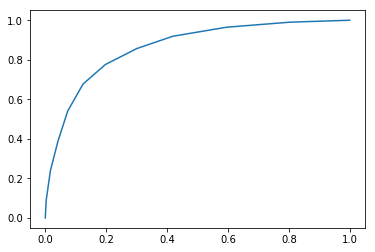

In [15]:
from sklearn.ensemble import RandomForestClassifier
randfor = RandomForestClassifier().fit(x_train, y_train)
predictedrf = randfor.predict(x_test)
accuracyrandfor = np.mean(predictedrf == y_test)
print('Accuracy for random forest is %.2f\n'%accuracyrandfor)
accuracy.update({'Random Forest': accuracyrandfor})

output(randfor, x_test, y_test, predictedrf)

We try to improve the model. Let's count the headline length into consideration and remove outliers from that.

Make a TF-IDF:
TF: Just counting the number of words in each document has 1 issue: it will give more weightage to longer documents than shorter documents. To avoid this, we can use frequency (TF - Term Frequencies) i.e. #count(word) / #Total words, in each document.

TF-IDF: Finally, we can even reduce the weightage of more common words like (the, is, an etc.) which occurs in all document. This is called as TF-IDF i.e Term Frequency times inverse document frequency.



2. Removing noise using Tfidvectorizer

{Convert a collection of raw documents to a matrix of TF-IDF features.

Equivalent to CountVectorizer followed by TfidfTransformer.}

https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [16]:
data['length'] = data['headline'].apply(lambda x: len(x.split(" ")))
data.head()

,headline,is_sarcastic,length
0,former versace store clerk sues over secret 'b...,0,12
1,the 'roseanne' revival catches up to our thorn...,0,14
2,mom starting to fear son's web series closest ...,1,14
3,"boehner just wants wife to listen, not come up...",1,13
4,j.k. rowling wishes snape happy birthday in th...,0,11


<BarContainer object of 32 artists>

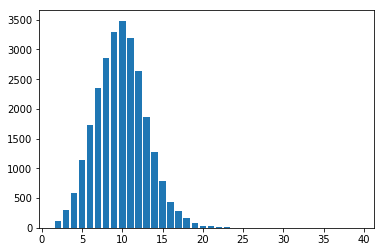

In [17]:
data_length = data['length'].value_counts().reset_index()
data_length.rename(columns={'index':'length', 'length':'frequency'}, inplace=True)
data_length.head()

plt.bar(data_length['length'], data_length['frequency'])

(26606, 3)


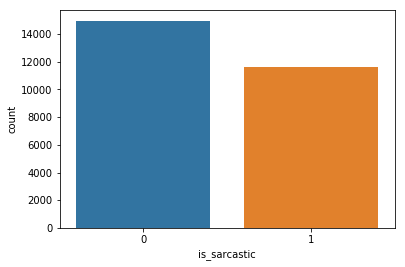

In [18]:
data = data[data['length'] < 20]
print(data.shape)
seaborn.countplot(data['is_sarcastic'])

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
m_feat = 3000
tf = TfidfVectorizer(analyzer = "word", ngram_range=(1,3), max_features=m_feat, norm="l2")
x_tf = tf.fit_transform(data['headline'])
y = data.is_sarcastic
x_train, x_test, y_train, y_test = train_test_split(x_tf, y, test_size = 0.2)

Accuracy is 0.83


Confusion matrix
 [[2538  500]
 [ 404 1880]]

Classification report
              precision    recall  f1-score   support

          0       0.86      0.84      0.85      3038
          1       0.79      0.82      0.81      2284

avg / total       0.83      0.83      0.83      5322


Error is 0.17



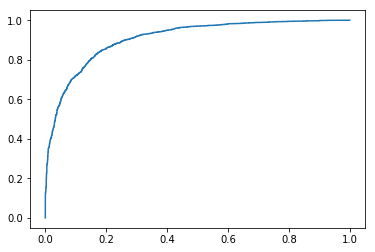

In [23]:
from sklearn.naive_bayes import BernoulliNB
naivebayes2 = BernoulliNB().fit(x_train, y_train)
predictednb2 = naivebayes2.predict(x_test)
accuracyNB = np.mean(predictednb2 == y_test)
print('Accuracy is %.2f\n'%accuracyNB)
accuracy.update({'Naive Bayes2': accuracyNB})

output(naivebayes2,x_test,y_test,predictednb2)

Accuracy is 0.84


Confusion matrix
 [[2619  419]
 [ 445 1839]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.86      0.86      3038
          1       0.81      0.81      0.81      2284

avg / total       0.84      0.84      0.84      5322


Error is 0.16



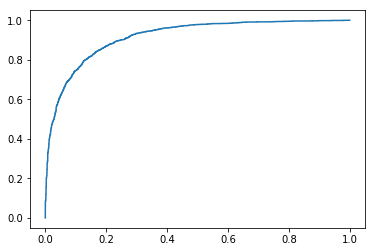

In [25]:
from sklearn.linear_model import LogisticRegression
logreg2 = LogisticRegression().fit(x_train,y_train)
predictedlr2 = logreg2.predict(x_test)
accuracyLR = np.mean(predictedlr2 == y_test)
print('Accuracy is %.2f\n'%accuracyLR)
accuracy.update({'Logistic Regression2': accuracyLR})

output(logreg2,x_test,y_test,predictedlr2)

In [26]:
from sklearn.linear_model import SGDClassifier
sgdcc = SGDClassifier(n_iter=5, random_state=42)
sgdc2 = sgdcc.fit(x_train, y_train)
predictedsgdc2 = sgdc2.predict(x_test)
accuracySGDC = np.mean(predictedsgdc2 == y_test)
print('Accuracy is %.2f\n'%accuracySGDC)
accuracy.update({'SGDC Classifier2': accuracySGDC})

output(sgdc2,x_test,y_test,predictedsgdc2)

Accuracy is 0.83


Confusion matrix
 [[2609  429]
 [ 475 1809]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.86      0.85      3038
          1       0.81      0.79      0.80      2284

avg / total       0.83      0.83      0.83      5322



/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


AttributeError: probability estimates are not available for loss='hinge'

Accuracy is 0.80


Confusion matrix
 [[2609  429]
 [ 475 1809]]

Classification report
              precision    recall  f1-score   support

          0       0.85      0.86      0.85      3038
          1       0.81      0.79      0.80      2284

avg / total       0.83      0.83      0.83      5322


Error is 0.17



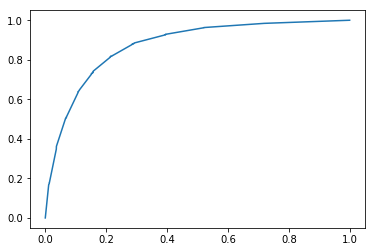

In [27]:
from sklearn.ensemble import RandomForestClassifier
randfor2 = RandomForestClassifier().fit(x_train, y_train)
predictedrf2 = randfor2.predict(x_test)
accuracyRANDFOR = np.mean(predictedrf2 == y_test)
print('Accuracy is %.2f\n'%accuracyRANDFOR)
accuracy.update({'SGDC Classifier': accuracyRANDFOR})

output(randfor2,x_test,y_test,predictedsgdc2)

next:
put all results into a table so we can pick the best model and try to figure why. (not sure if we can do this for all, but maybe we can visualize the ROC curves for models)
or, even loop and check where we get the best result for a few values of max_features and pick that one.
make wordcloud using this model of most common words in sarcastic and non-sarcastic text

In [38]:
accuracy_df = pd.DataFrame.from_dict(accuracy, orient = 'index', columns= 'Accuracy')
print(accuracy_df)

   Naive Bayes  Logistic Regression  SGDC Classifier  Random Forest  \
0     0.846312             0.838076         0.799511       0.788843   

   Naive Bayes2  Logistic Regression2  SGDC Classifier2  
0      0.830139              0.837655          0.830139  


So the first Naive Bayes gives us the best result. Let's take variables from that to find out the most common words in sarcastic versus non-sarcastic text using wordclouds.

scipy.sparse.csr.csr_matrix